In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import seaborn as sns
from datetime import datetime

## 数据导入

### 导入1-7月数据

In [2]:
def mergedf(df_04,df_15,month):
    length=len(df_04)
    
    times=[]
    #计算奶牛年龄
    for i in df_04.index:
        a1=datetime.strptime(df_04.loc[i,'出生日期'],"%Y-%M-%d")
        a2=datetime.strptime(df_04.loc[i,'采样日期'],"%Y-%M-%d")
        day=(a2-a1).days
        times.append(day)
    df_age=df_04
    df_age['年龄']=times
    #记录月份
    df_month=df_age
    df_month['月份']=month
    #提取乳糖和总固
    df_cellscore=df_month
    df_seg=df_15.loc[:,['牛号','乳糖','总固']]
    df_cellscore['牛号']=df_cellscore['牛号'].astype(int)
    df=pd.merge(left=df_cellscore,right=df_seg,left_on='牛号',right_on='牛号',how='left')
    return df

In [3]:
# 乳成分分析（体细胞数、乳糖、蛋白、乳脂、总固体）
# 导入1-7月数据
frames=[]
keysType=[]
for i in range(1,8):
    path_04=r'data/XXXX/XXXXX(2022-0'+str(i)+')XXXXXXXXXX/04综合测定结果表.xls'
    path_15=r'data/XXXX/XXXXX(2022-0'+str(i)+')XXXXXXXXXX/15采样记录表.xls'
    df_04=pd.read_excel(path_04,sheet_name='Sheet1')
    df_15=pd.read_excel(path_15,sheet_name='15采样记录表')
    # 删除小计
    df_04=df_04[-df_04['牛号'].isin(['小计','平均与总计'])]
    
    df=mergedf(df_04,df_15,i)
    frames.append(df)
    keysType.append(str(i)+'月')

# 合并连接
df=pd.concat(frames,keys=keysType)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 25155 entries, ('1月', 0) to ('7月', 4013)
Data columns (total 37 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   序号          25155 non-null  float64
 1   牛号          25155 non-null  int32  
 2   出生日期        25155 non-null  object 
 3   胎次(胎)       25155 non-null  float64
 4   采样日期        25155 non-null  object 
 5   产犊日期        25155 non-null  object 
 6   产犊间隔(天)     1504 non-null   float64
 7   泌乳天数(天)     25155 non-null  float64
 8   分组号         24499 non-null  object 
 9   产奶量(Kg)     25155 non-null  float64
 10  乳脂率(%)      25155 non-null  float64
 11  蛋白率(%)      25155 non-null  float64
 12  脂蛋比         25155 non-null  float64
 13  体细胞数(万/ml)  25155 non-null  float64
 14  体细胞分        25155 non-null  float64
 15  尿素氮(mg/dl)  25155 non-null  float64
 16  奶损失(Kg)     25155 non-null  float64
 17  奶款差         25155 non-null  float64
 18  经济损失        25155 non-null  float64
 19  校正奶(Kg)   

In [4]:
# data
data=df

In [5]:
data.shape

(25155, 37)

## 数据处理

### 删除多余列

In [6]:
# 删除序号列
data.drop(columns=['序号'],inplace=True)
# 删除小计
data=data[-data['牛号'].isin(['小计','平均与总计'])]
# 删除牛号列
data.drop(columns=['牛号'],inplace=True)

### 数据去空

In [7]:
# 各变量中缺失值的数量
data.isnull().sum(axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 25155 entries, ('1月', 0) to ('7月', 4013)
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   出生日期        25155 non-null  object 
 1   胎次(胎)       25155 non-null  float64
 2   采样日期        25155 non-null  object 
 3   产犊日期        25155 non-null  object 
 4   产犊间隔(天)     1504 non-null   float64
 5   泌乳天数(天)     25155 non-null  float64
 6   分组号         24499 non-null  object 
 7   产奶量(Kg)     25155 non-null  float64
 8   乳脂率(%)      25155 non-null  float64
 9   蛋白率(%)      25155 non-null  float64
 10  脂蛋比         25155 non-null  float64
 11  体细胞数(万/ml)  25155 non-null  float64
 12  体细胞分        25155 non-null  float64
 13  尿素氮(mg/dl)  25155 non-null  float64
 14  奶损失(Kg)     25155 non-null  float64
 15  奶款差         25155 non-null  float64
 16  经济损失        25155 non-null  float64
 17  校正奶(Kg)     25155 non-null  float64
 18  持续力         22775 non-null  float64
 19  WHI       

### 数据筛选

In [8]:
data=data.drop(data[(data.iloc[:,5]<5)|(data.iloc[:,5]>405)].index)# 删除泌乳天数异常牛只
data=data.drop(data[(data.iloc[:,8]>7.0)|(data.iloc[:,8]<2.0)].index) #删除乳脂率异常牛只
data=data.drop(data[(data.iloc[:,9]>5.0)|(data.iloc[:,9]<2.0)].index) #删除乳蛋白异常牛只
data=data.drop(data[(data.iloc[:,26]<2.0)].index) #删除305d产奶量异常牛只
data.iloc[:,11]+=0.1 #令体细胞数不为0
data.iloc[:,12]+=0.1 #令体细胞分不为0
data.iloc[:,21]+=0.1 #令前体细胞数不为0
data.iloc[:,22]+=0.1 #令前体细胞分不为0

In [9]:
# 删除 '产犊日期','产犊间隔(天)','分组号','出生日期','采样日期' 列
data=data.drop(['产犊日期','产犊间隔(天)','分组号','出生日期','采样日期'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24835 entries, ('1月', 0) to ('7月', 4012)
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   胎次(胎)       24835 non-null  float64
 1   泌乳天数(天)     24835 non-null  float64
 2   产奶量(Kg)     24835 non-null  float64
 3   乳脂率(%)      24835 non-null  float64
 4   蛋白率(%)      24835 non-null  float64
 5   脂蛋比         24835 non-null  float64
 6   体细胞数(万/ml)  24835 non-null  float64
 7   体细胞分        24835 non-null  float64
 8   尿素氮(mg/dl)  24835 non-null  float64
 9   奶损失(Kg)     24835 non-null  float64
 10  奶款差         24835 non-null  float64
 11  经济损失        24835 non-null  float64
 12  校正奶(Kg)     24835 non-null  float64
 13  持续力         22523 non-null  float64
 14  WHI         24835 non-null  float64
 15  前奶量(Kg)     22523 non-null  float64
 16  前体细胞(万/ml)  22523 non-null  float64
 17  前体细胞分       22523 non-null  float64
 18  前奶损失(Kg)    22523 non-null  float64
 19  高峰奶(Kg)   

In [10]:
# 删除空行
data.dropna(inplace=True)

### 样本&标记

In [11]:
# y列放到最后一列
protein=data.pop('体细胞数(万/ml)')
data.insert(loc=data.shape[1],column='体细胞数(万/ml)',value=protein,allow_duplicates=False)

### 数据可视化

In [12]:
# 加载中文字体相关
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# fname字体文件的路径
font = fm.FontProperties(fname=r'C:\WINDOWS\Fonts\simhei.ttf')
#设置绘图风格
plt.style.use('ggplot')
#处理中文乱码
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

#### 热力图相关性

<AxesSubplot:>

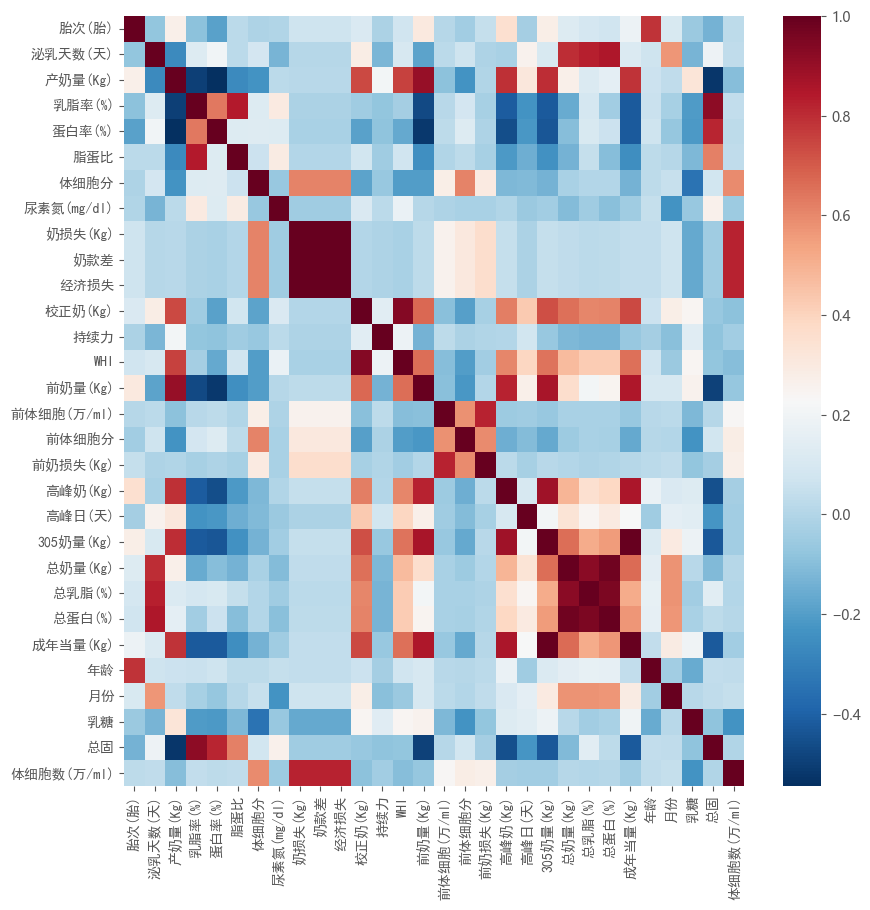

In [13]:
# 查看属性相关性
mask=np.triu(np.ones_like(data.corr(method='pearson'),dtype=bool))
fig,ax=plt.subplots(figsize=(10,10))
plt.xticks(fontproperties=font)
plt.yticks(fontproperties=font)
sns.heatmap(data.corr(method='pearson'),fmt='.1g',ax=ax,cmap="RdBu_r")

#### 相关性筛选

In [14]:
# 相关性筛选
def correlation(df,threshold):
    correlated_cols=set()
    corr_matrix=df.corr()
    for i in range(len(corr_matrix)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold:
                colname=corr_matrix.columns[i]
                correlated_cols.add(colname)
    return correlated_cols

In [15]:
# 相关性过高去掉
corr_feature=correlation(data,0.66)
corr_feature

{'305奶量(Kg)',
 'WHI',
 '体细胞数(万/ml)',
 '前奶损失(Kg)',
 '前奶量(Kg)',
 '奶款差',
 '年龄',
 '总乳脂(%)',
 '总固',
 '总奶量(Kg)',
 '总蛋白(%)',
 '成年当量(Kg)',
 '校正奶(Kg)',
 '经济损失',
 '脂蛋比',
 '高峰奶(Kg)'}

In [16]:
# 删除 产犊间隔(天) 列
data=data.drop([
 '305奶量(Kg)',
 'WHI',
 '前奶损失(Kg)',
 '前奶量(Kg)',
 '奶损失(Kg)',
 '奶款差',
 '年龄',#新增
 '总乳脂(%)',
 '总固',#新增
 '总奶量(Kg)',
 '总蛋白(%)',
 '成年当量(Kg)',
 '校正奶(Kg)',
 '经济损失',
 '脂蛋比',
 '高峰奶(Kg)'],axis=1)

### 数据备份

In [17]:
# 数据预处理完毕，备份
targetCSVPath='data/XXXX/XXXXXXX-(1-7月).xlsx'
data.to_excel(targetCSVPath,index=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19591 entries, ('1月', 0) to ('7月', 4012)
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   胎次(胎)       19591 non-null  float64
 1   泌乳天数(天)     19591 non-null  float64
 2   产奶量(Kg)     19591 non-null  float64
 3   乳脂率(%)      19591 non-null  float64
 4   蛋白率(%)      19591 non-null  float64
 5   体细胞分        19591 non-null  float64
 6   尿素氮(mg/dl)  19591 non-null  float64
 7   持续力         19591 non-null  float64
 8   前体细胞(万/ml)  19591 non-null  float64
 9   前体细胞分       19591 non-null  float64
 10  高峰日(天)      19591 non-null  float64
 11  月份          19591 non-null  int64  
 12  乳糖          19591 non-null  float64
 13  体细胞数(万/ml)  19591 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 2.3+ MB
